# Deep Learning - Assigment 1

### Group Number: 22

### Teammates:
1. **Mahshid Jafar Tajrishi**
2. **Bar Melinarskiy**
3. **Cis van Aken**
4. **Simon van Klompenburg**

## Imports entire notebook

In [1]:
# Helper function to check if the code is running in Google Colab
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Usage
if is_colab():
    print("Running in Google Colab")
else:
    print("Not running in Google Colab")


# Importing libraries
import pandas as pd
import numpy as np
from scipy.io import loadmat
from IPython.display import display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast  # Add these imports for mixed precision training
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, TensorDataset
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from tqdm.auto import tqdm


import os
import shutil
import subprocess
import zipfile
import re
import random




Not running in Google Colab


c:\Users\Surface\anaconda3\envs\deeplearning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Global Definitions

In [2]:
# Path to the zip file
data_dir = "./Data"
data_path = f"{data_dir}/Xtrain.mat"

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

In [3]:
# Check if CUDA is available
print(torch.__version__)
print(torch.version.cuda)  # Should match CUDA 12.5
print(torch.backends.cudnn.version())  # Should return a version, not None
print(torch.cuda.is_available())  # Should return True

2.5.1
None
None
False


In [4]:
# If we are in colab and we need to mount the drive
if is_colab():
  from google.colab import drive
  # Mount Google Drive
  drive.mount('/content/drive')
  print("Google Drive mounted successfully.")
  data_path = f"/content/drive/MyDrive/{data_path}"
else:
  print("Not in Google Colab.")

Not in Google Colab.


# Load Data

In [5]:
train_dataset = loadmat(data_path)
Xtrain = train_dataset['Xtrain']
# Check the shape of the data
print("Shape of Xtrain:", Xtrain.shape)

# Display the first few rows of the data
print("First 10 rows of Xtrain:")
print(Xtrain[:10])

#Normalizing
mean, std = Xtrain.mean(), Xtrain.std()
Xtrain_normalize = (Xtrain - mean) / std 

# Display the first few rows of the data
print("First 10 rows of Xtrain_normalize:")
print(Xtrain_normalize[:10])


Shape of Xtrain: (1000, 1)
First 10 rows of Xtrain:
[[ 86]
 [141]
 [ 95]
 [ 41]
 [ 22]
 [ 21]
 [ 32]
 [ 72]
 [138]
 [111]]
First 10 rows of Xtrain_normalize:
[[ 0.55720154]
 [ 1.73111118]
 [ 0.74929585]
 [-0.40326998]
 [-0.8088024 ]
 [-0.83014621]
 [-0.59536428]
 [ 0.25838818]
 [ 1.66707975]
 [ 1.09079683]]


### Utilities 

In [6]:
def create_sequences(data, window_size):
    """
    Spliting the data into subsets using Sliding Window

    Import : 
    data : Array of numbers with the sequence of the laser measurements 
    window_size : Integer the sliding window size 

    Return : 
    X : An array of subsets 
    y : An array of labels for X 
    """
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Function to prepare DataLoader
def prepare_dataloader(series, window_size, batch_size=64):
    """
    Preprocess the datasets for the transformer model

    Import: 
    series : Array of numbers with the sequence of the laser measurements 
    window_size: Integer the sliding window size
    batch_size: The number of samples used in one foreward and backward pass through the network 
    """
    X, y = create_sequences(series, window_size)
    # Ensure proper shapes: X → (N, seq_len, 1), y → (N, 1)
    X = torch.tensor(X, dtype=torch.float32)
    if X.ndim == 2:
        X = X.unsqueeze(-1)  # from (N, seq_len) to (N, seq_len, 1)
    y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  # (N,) → (N, 1)
    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True), X, y

    
def train_model(model, dataloader, X_all, y_all, std, mean, epochs=20, lr=1e-3):
    """
        Training the given model 

        Import : 
        model: The givene model to train 
        dataloader: A generic utility for data fitching 
        epochs: Integer the number of itterations to train the model 
        threshold : A float - A cut-off for stopping
        lr: A float - learning rate 

        Return: 
        train_model : A model which was trained 
    """ 

    model.to(device)
    mse_criterion = nn.MSELoss()
    mae_criterion = nn.L1Loss()
    mse_losses, mae_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_mse, total_mae, total = 0.0, 0.0, 0

        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch_x, batch_y in pbar:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            preds = model(batch_x)

            loss = mse_criterion(preds, batch_y)

            optimizer = optim.Adam(model.parameters(), lr=lr)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_size = batch_x.size(0)
            total += batch_size
            total_mse += mse_criterion(preds, batch_y).item() * batch_size
            total_mae += mae_criterion(preds, batch_y).item() * batch_size

            pbar.set_postfix(mse=loss.item())

        avg_mse = total_mse / total
        avg_mae = total_mae / total
        mse_losses.append(avg_mse)
        mae_losses.append(avg_mae)

        print(f"Epoch {epoch+1}: MSE={avg_mse:.4f}, MAE={avg_mae:.4f}")

        plot_metrics(
            mse_losses, mae_losses, model, X_all, y_all, std, mean,
            save_path=f"training_epoch_{epoch+1}.png",
            current_epoch=epoch + 1
        )

    return mse_losses, mae_losses


def plot_metrics(mse_losses, mae_losses, model, X_all, y_all, std, mean, save_path="training_summary.png", current_epoch=None):
    model.eval()
    device = next(model.parameters()).device

    with torch.no_grad():
        preds = model(X_all.to(device)).cpu().numpy().flatten()
    true_vals = y_all.numpy().flatten()

    # Rescale
    preds_rescaled = preds * std + mean
    true_rescaled = true_vals * std + mean
    residuals = preds_rescaled - true_rescaled

    title_suffix = f" (Epoch {current_epoch})" if current_epoch is not None else ""

    plt.figure(figsize=(18, 10))

    # 1. MSE Loss
    plt.subplot(2, 3, 1)
    plt.plot(mse_losses, label="MSE Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training MSE Loss" + title_suffix)
    plt.legend()

    # 2. MAE Loss
    plt.subplot(2, 3, 2)
    plt.plot(mae_losses, label="MAE Loss", color="green")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training MAE Loss" + title_suffix)
    plt.legend()

    # 3. Prediction vs True (Scatter)
    plt.subplot(2, 3, 3)
    plt.scatter(true_rescaled, preds_rescaled, alpha=0.5)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("Predicted vs. True (Rescaled)" + title_suffix)
    plt.grid(True)

    # 4. Residuals Histogram
    plt.subplot(2, 3, 4)
    plt.hist(residuals, bins=50, color="orange")
    plt.xlabel("Prediction Error")
    plt.title("Residuals Distribution" + title_suffix)

    # 5. Time Series Comparison
    plt.subplot(2, 3, 5)
    plt.plot(true_rescaled[-200:], label="True")
    plt.plot(preds_rescaled[-200:], label="Predicted")
    plt.title("Last 200 Points: True vs. Predicted" + title_suffix)
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

    print(f"Plot exported to: {save_path}")
   


def recursive_forecast(model, init_window, steps=200):
    model.eval()
    preds = []
    current_seq = init_window.clone().to(device)

    with torch.no_grad():
        for _ in range(steps):
            pred = model(current_seq.unsqueeze(0))  # shape: (1, seq_len, 1)
            preds.append(pred.item())
            current_seq = torch.cat((current_seq[1:], pred.cpu()), dim=0)

    # Rescale back
    return np.array(preds) * std + mean

### Transformer Model

In [7]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim=1, model_dim=64, num_heads=4, num_layers=2):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_proj = nn.Linear(model_dim, 1)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.transformer(x)
        return self.output_proj(x[:, -1])  # last token


### Training the Model 

Epoch 1/20:   0%|          | 0/15 [00:00<?, ?it/s]c:\Users\Surface\anaconda3\envs\deeplearning\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Surface\anaconda3\envs\deeplearning\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\Surface\anaconda3\envs\deeplearning\Lib\site-packages\torch\nn\modules\loss.py:128: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64

Epoch 1: MSE=2.3894, MAE=1.2130


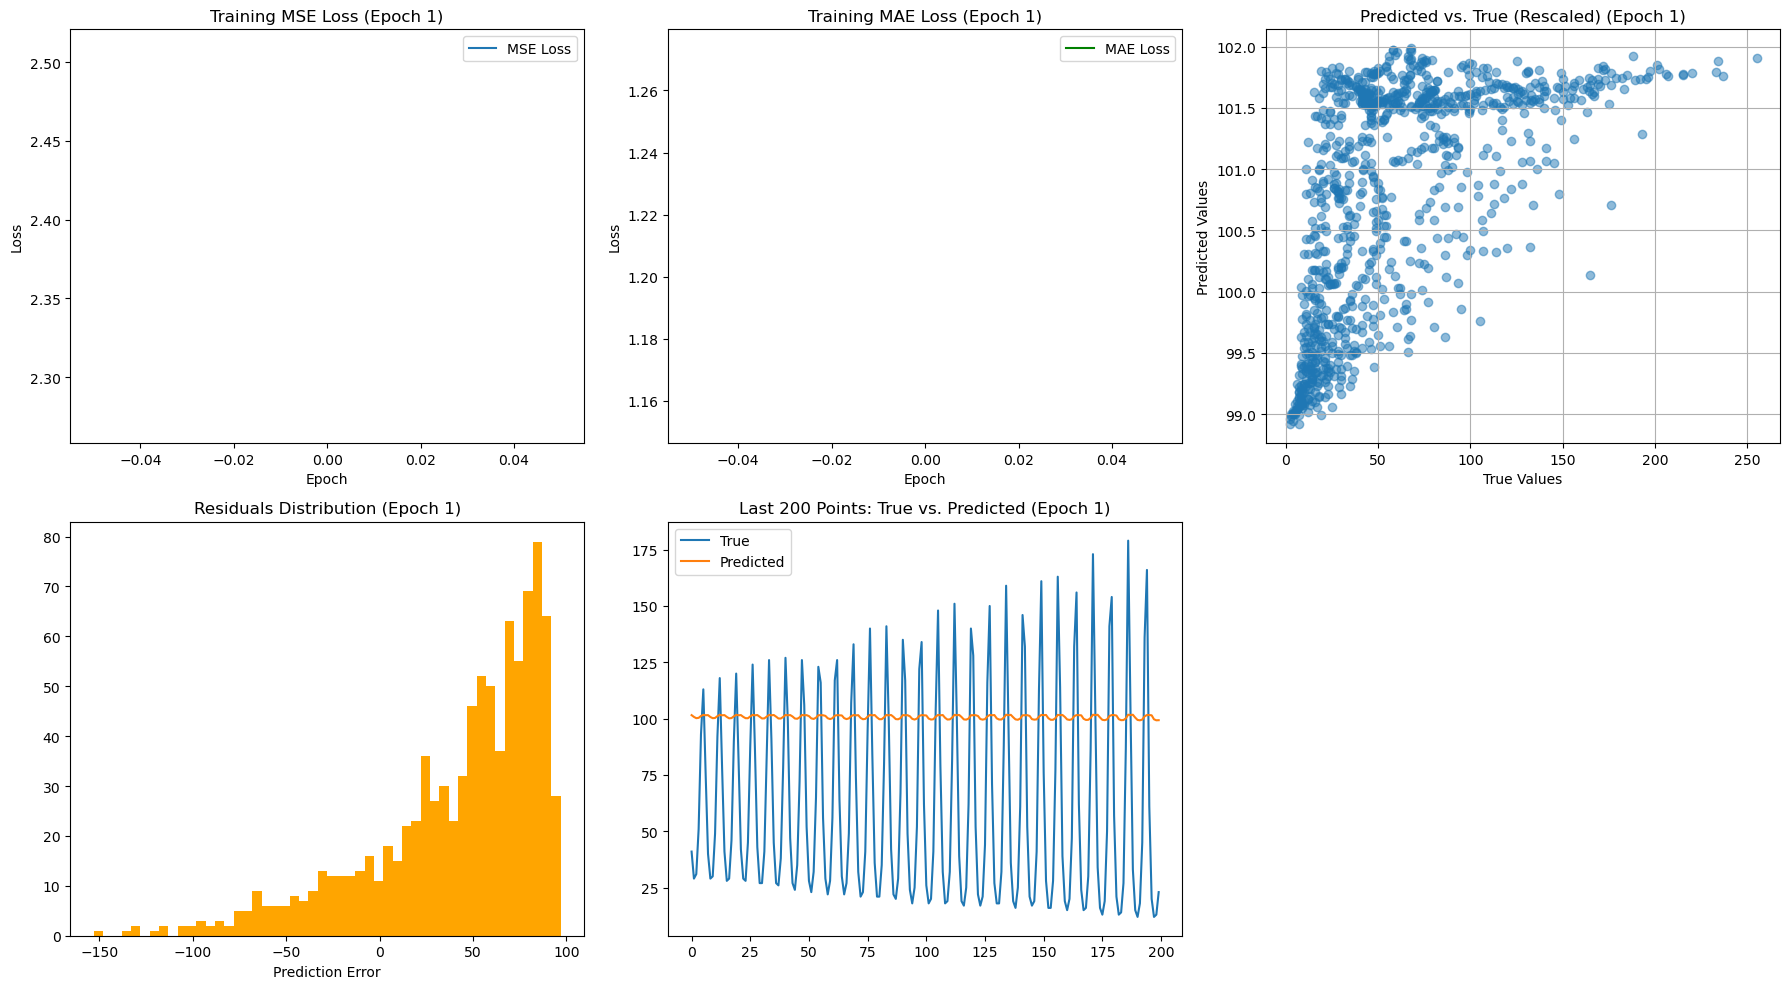

Plot exported to: training_epoch_1.png


Epoch 2/20: 100%|██████████| 15/15 [00:05<00:00,  2.76it/s, mse=1]    


Epoch 2: MSE=1.2429, MAE=0.8935


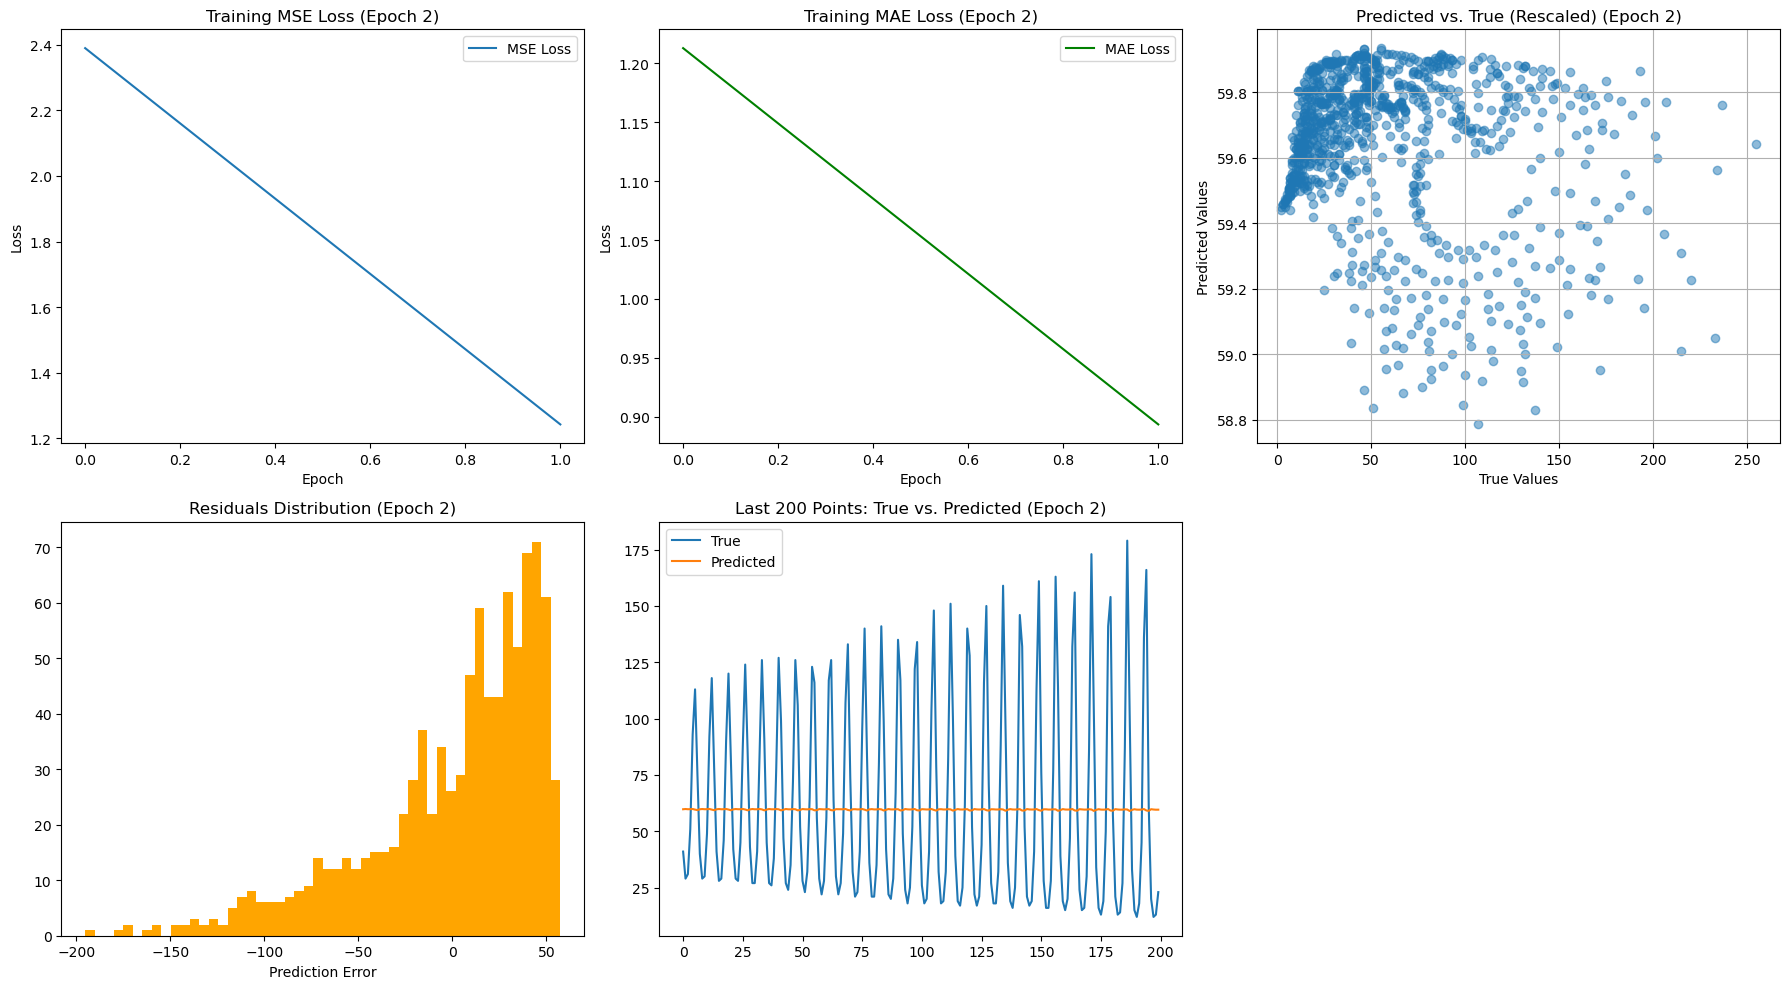

Plot exported to: training_epoch_2.png


Epoch 3/20: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s, mse=1.02]


Epoch 3: MSE=1.1162, MAE=0.8210


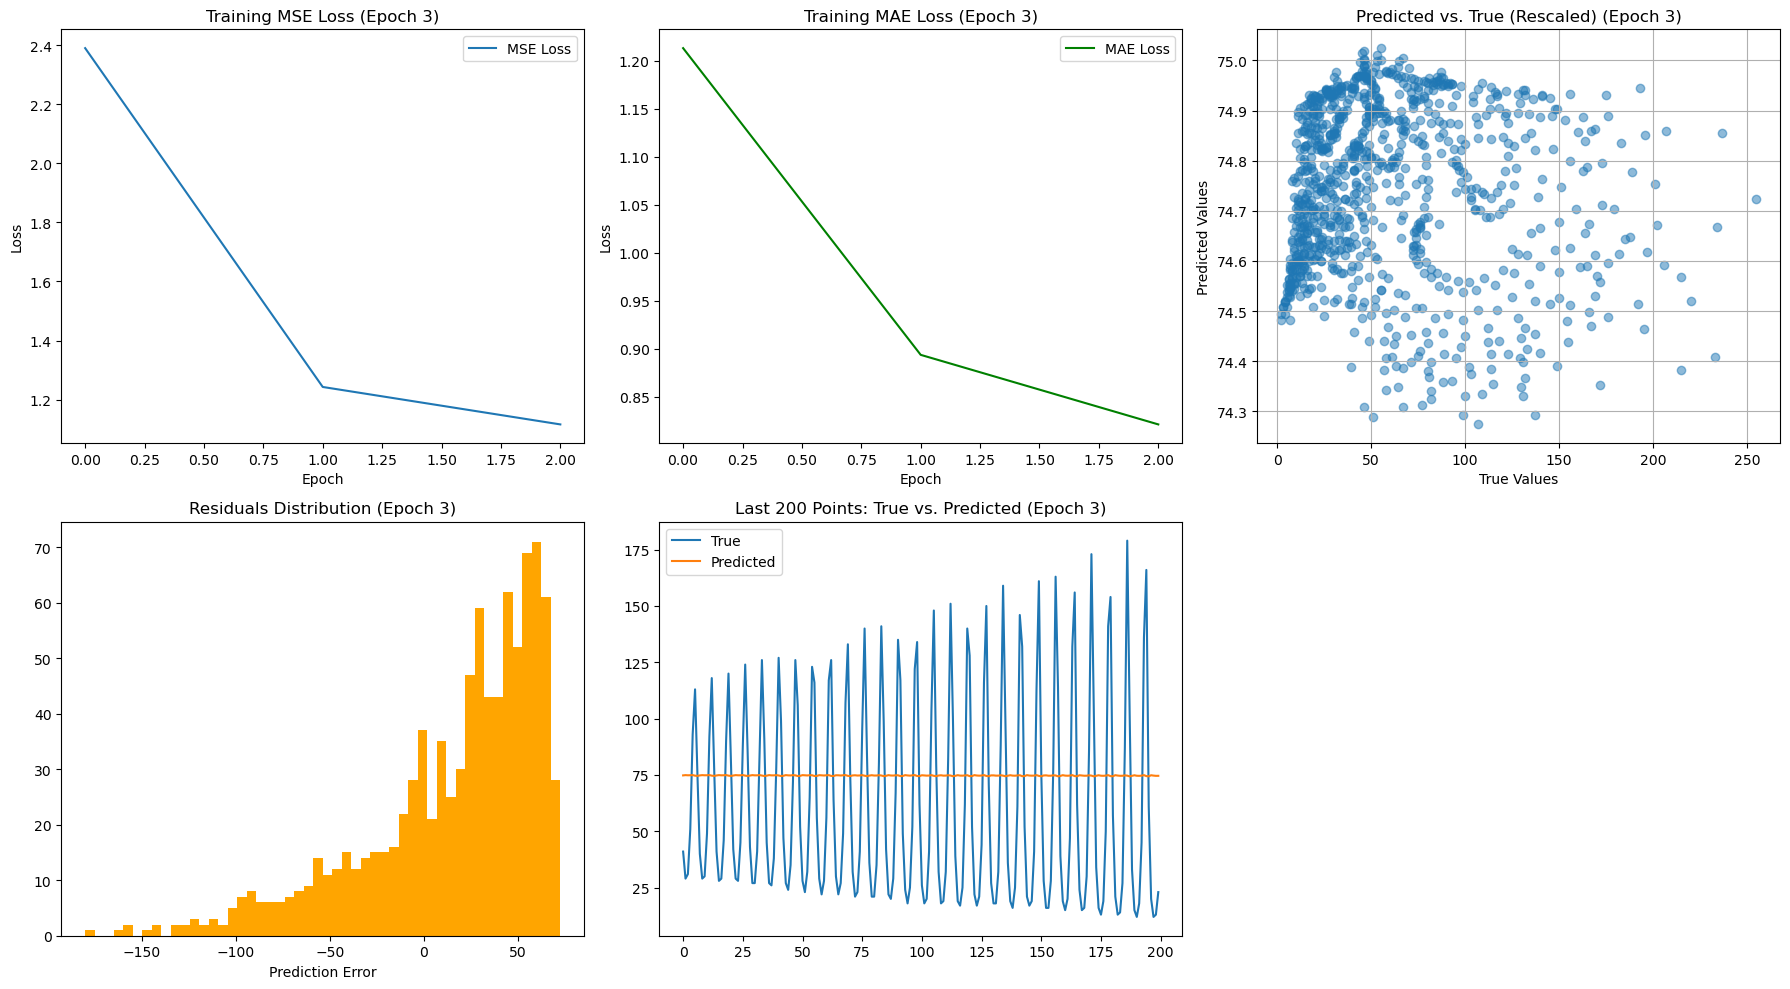

Plot exported to: training_epoch_3.png


Epoch 4/20: 100%|██████████| 15/15 [00:07<00:00,  2.10it/s, mse=1.44] 


Epoch 4: MSE=1.0297, MAE=0.8138


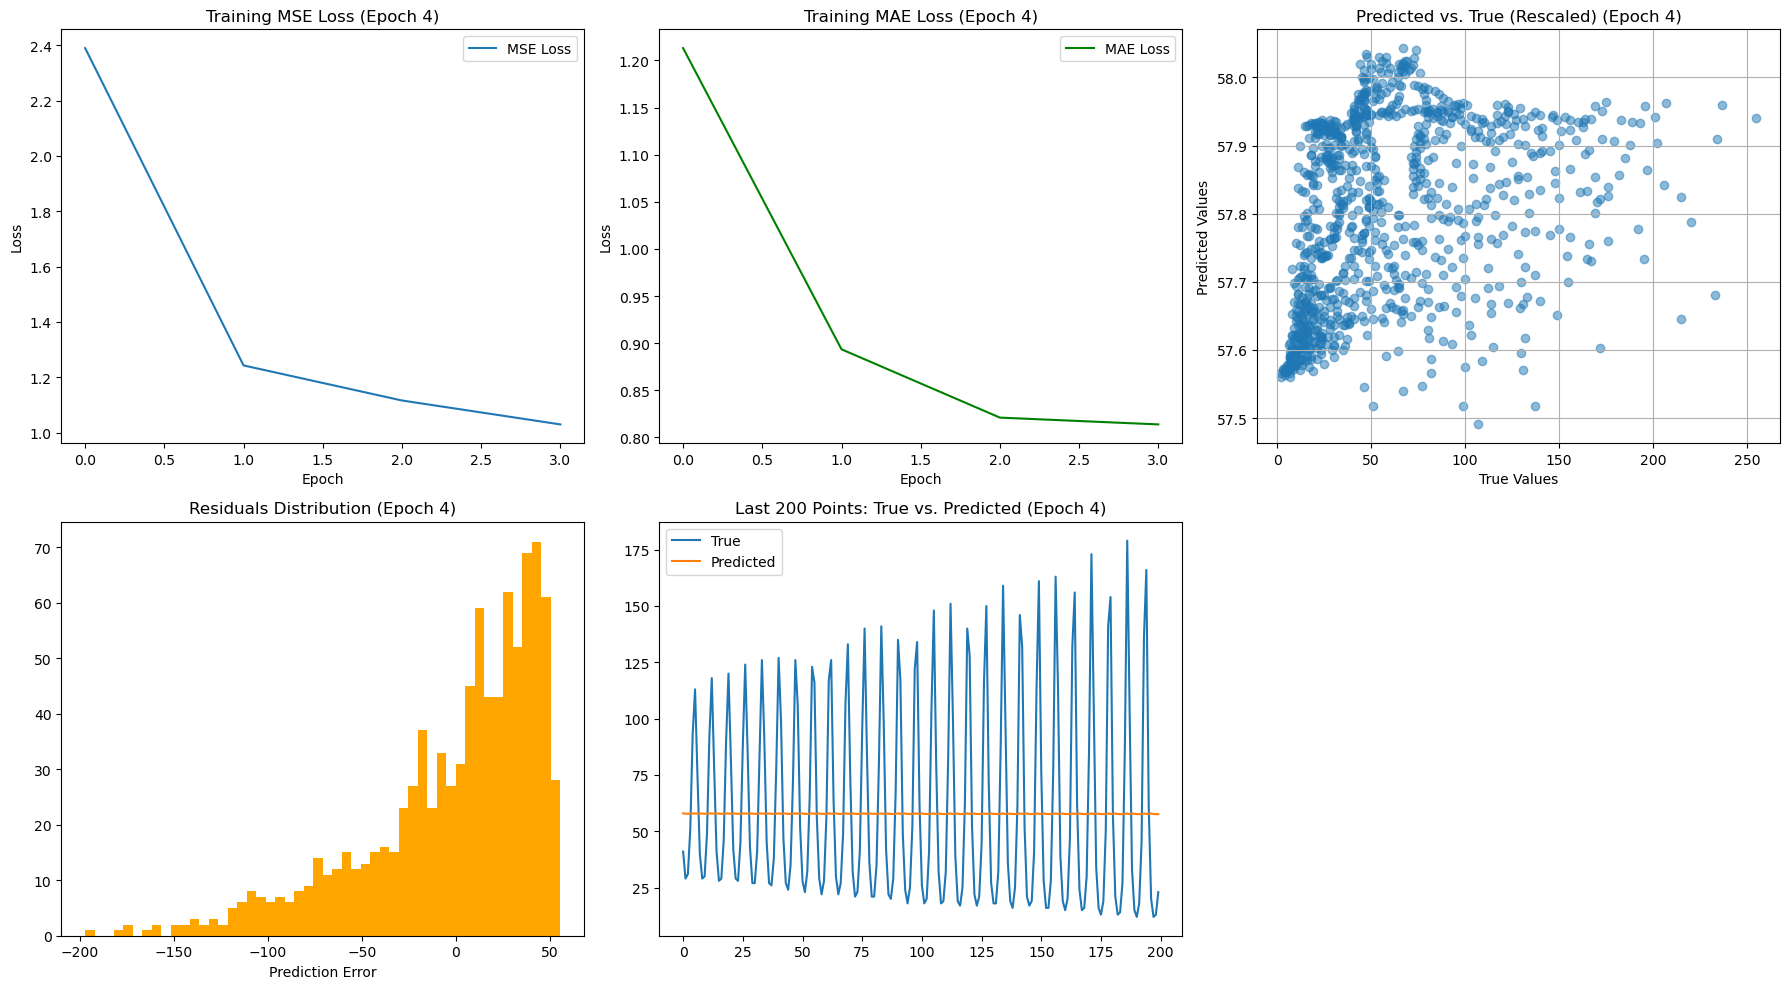

Plot exported to: training_epoch_4.png


Epoch 5/20: 100%|██████████| 15/15 [00:06<00:00,  2.49it/s, mse=1.51] 


Epoch 5: MSE=1.0292, MAE=0.7811


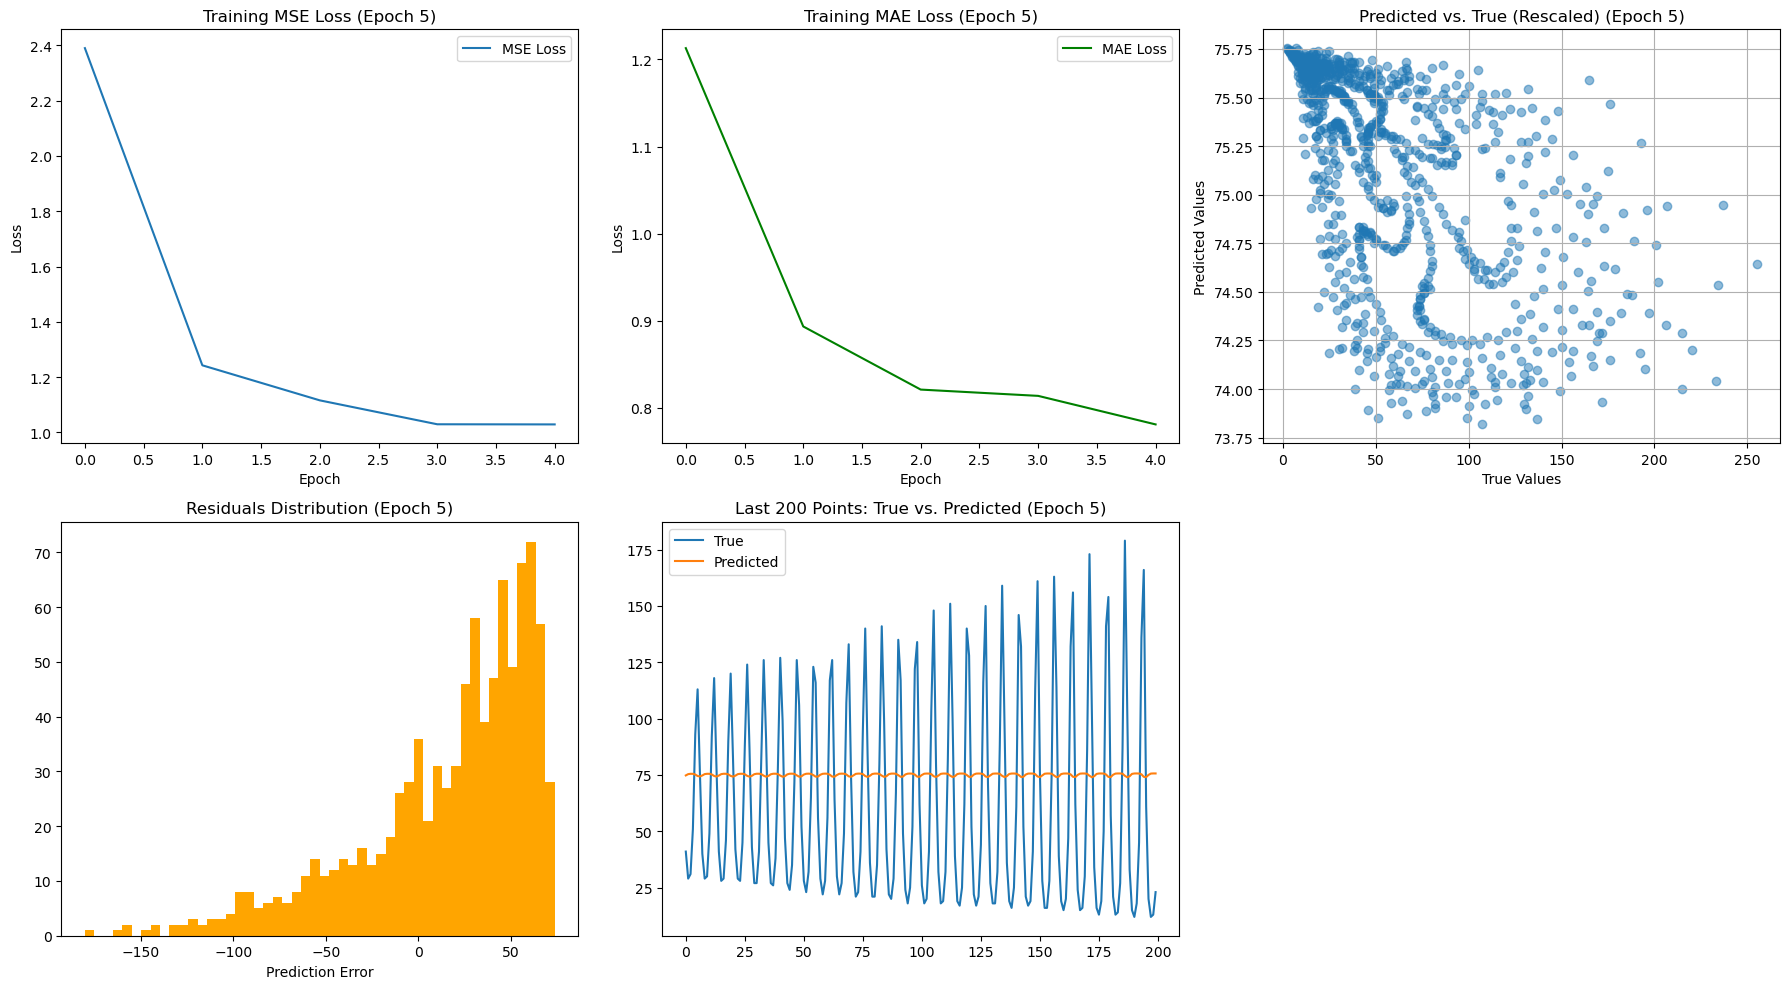

Plot exported to: training_epoch_5.png


Epoch 6/20: 100%|██████████| 15/15 [00:05<00:00,  2.84it/s, mse=1]    


Epoch 6: MSE=1.0041, MAE=0.7937


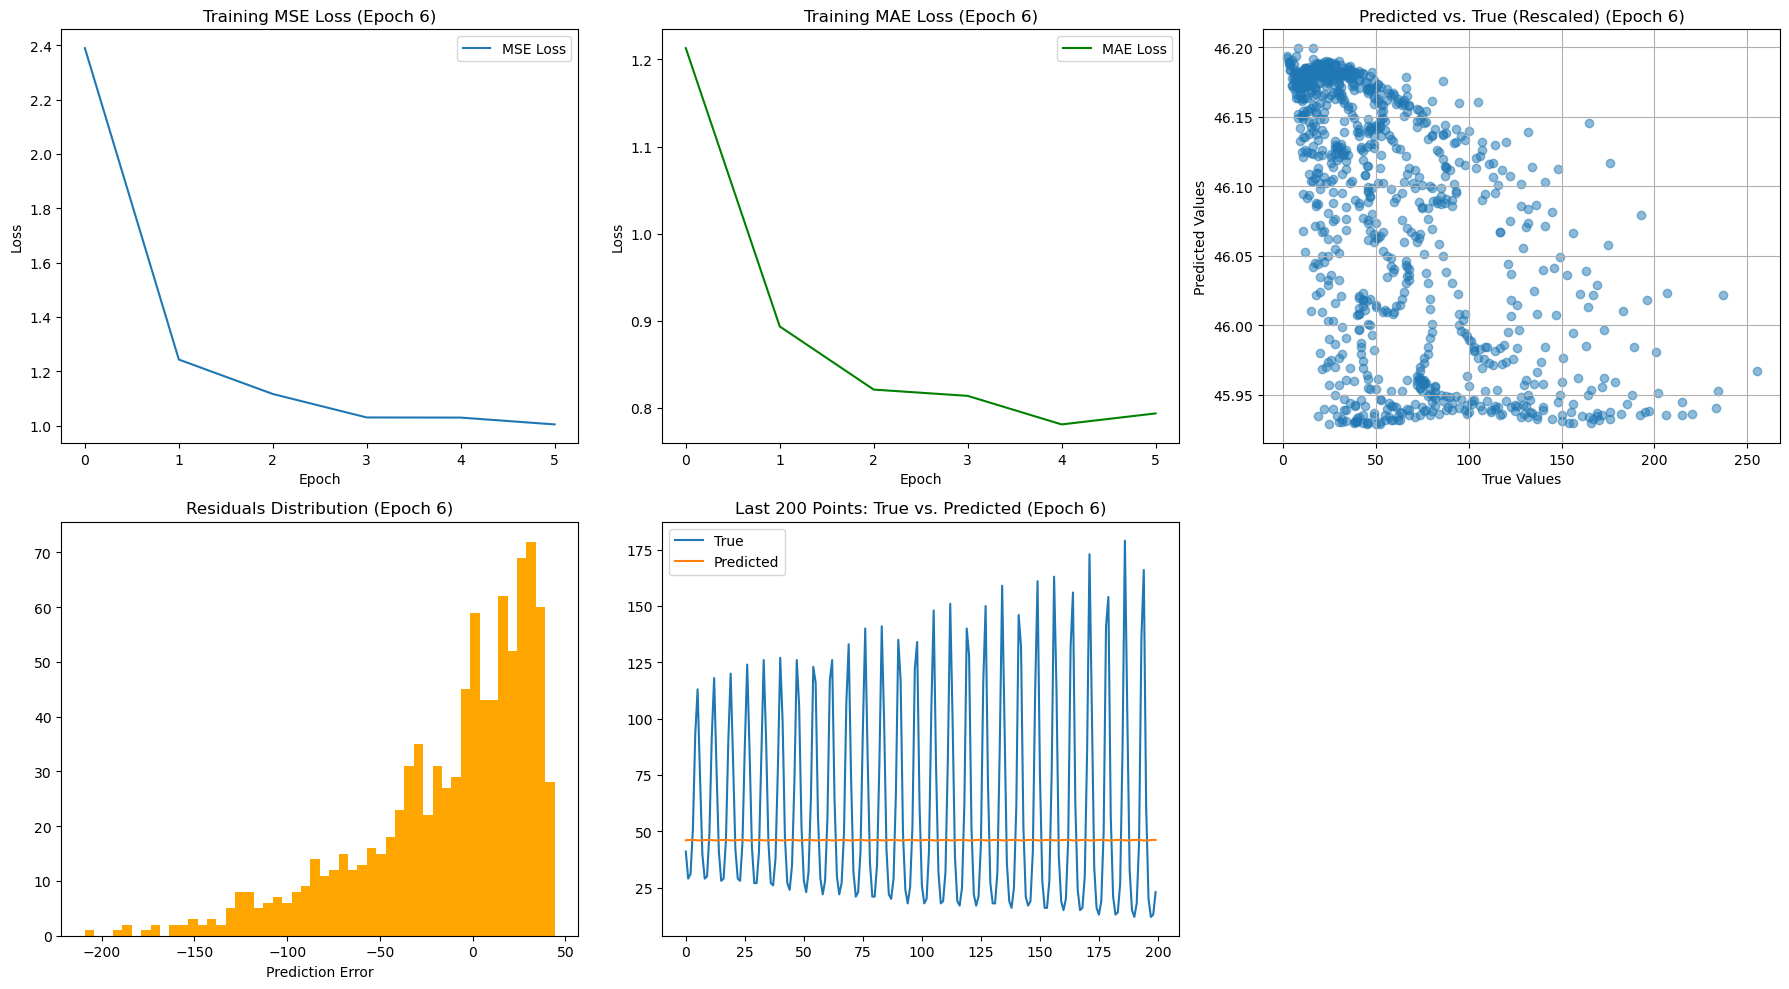

Plot exported to: training_epoch_6.png


Epoch 7/20: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s, mse=1.01] 


Epoch 7: MSE=1.0132, MAE=0.7994


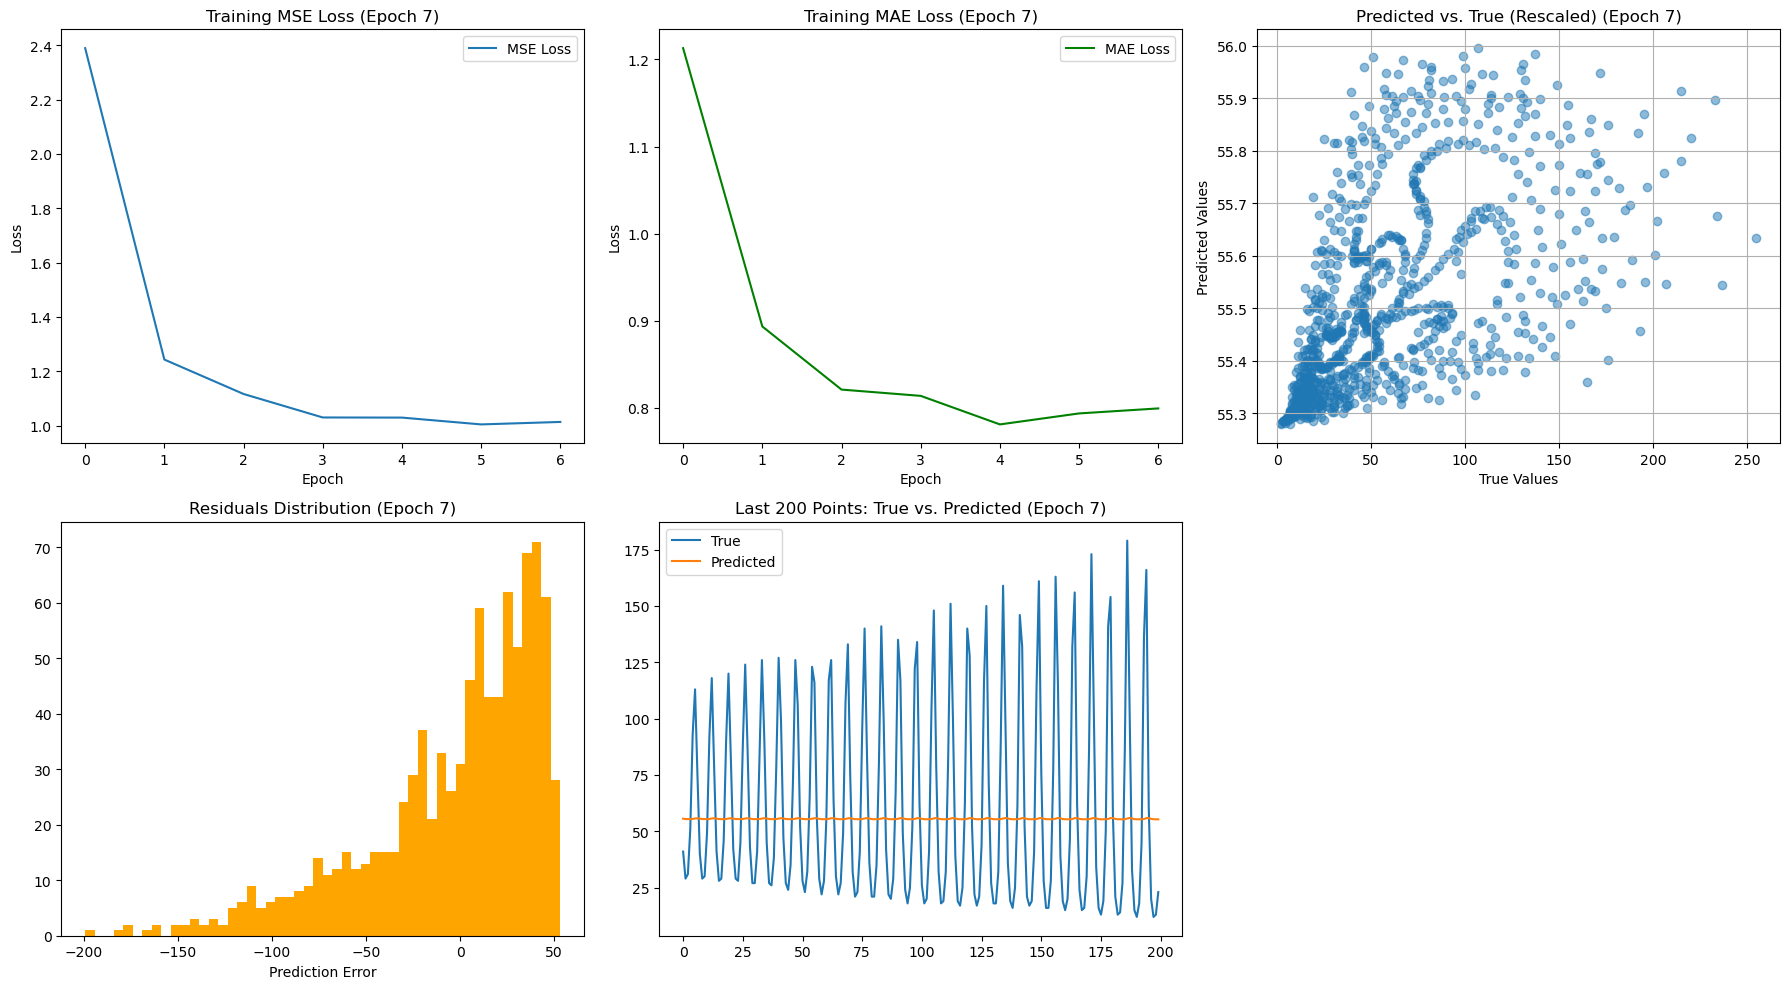

Plot exported to: training_epoch_7.png


Epoch 8/20: 100%|██████████| 15/15 [00:15<00:00,  1.03s/it, mse=1.13] 


Epoch 8: MSE=1.0176, MAE=0.7912


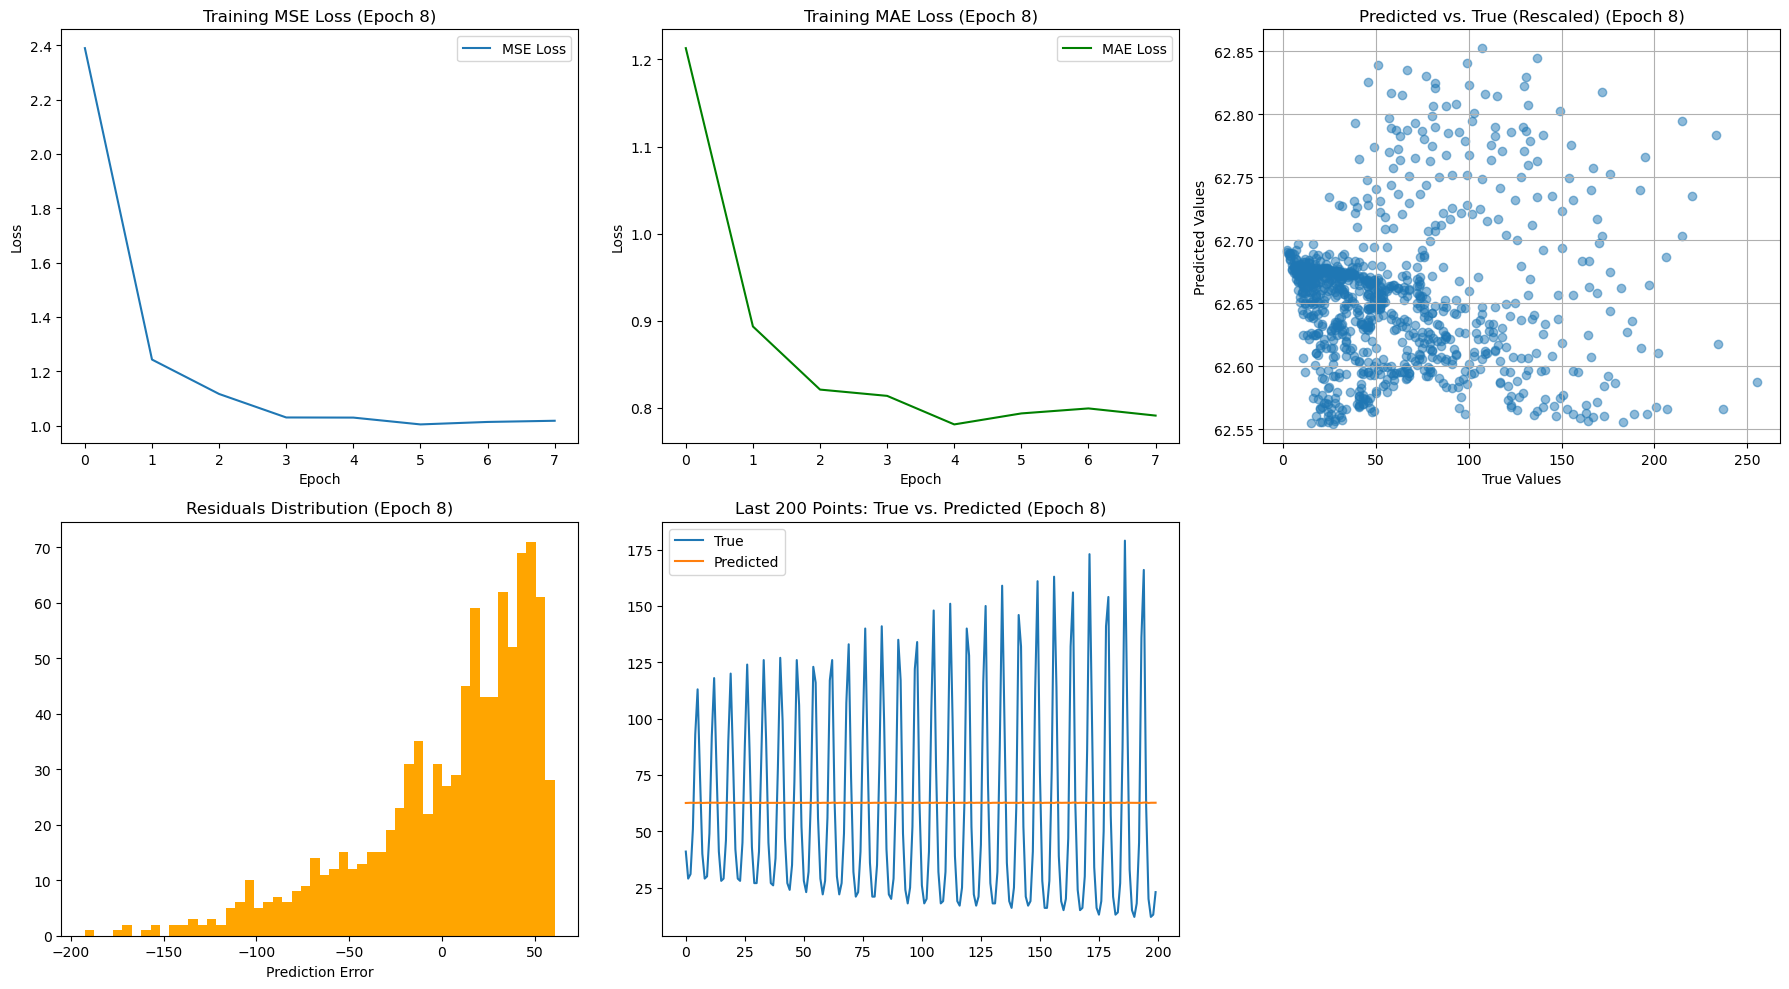

Plot exported to: training_epoch_8.png


Epoch 9/20: 100%|██████████| 15/15 [00:06<00:00,  2.20it/s, mse=1.38] 


Epoch 9: MSE=1.0126, MAE=0.7884


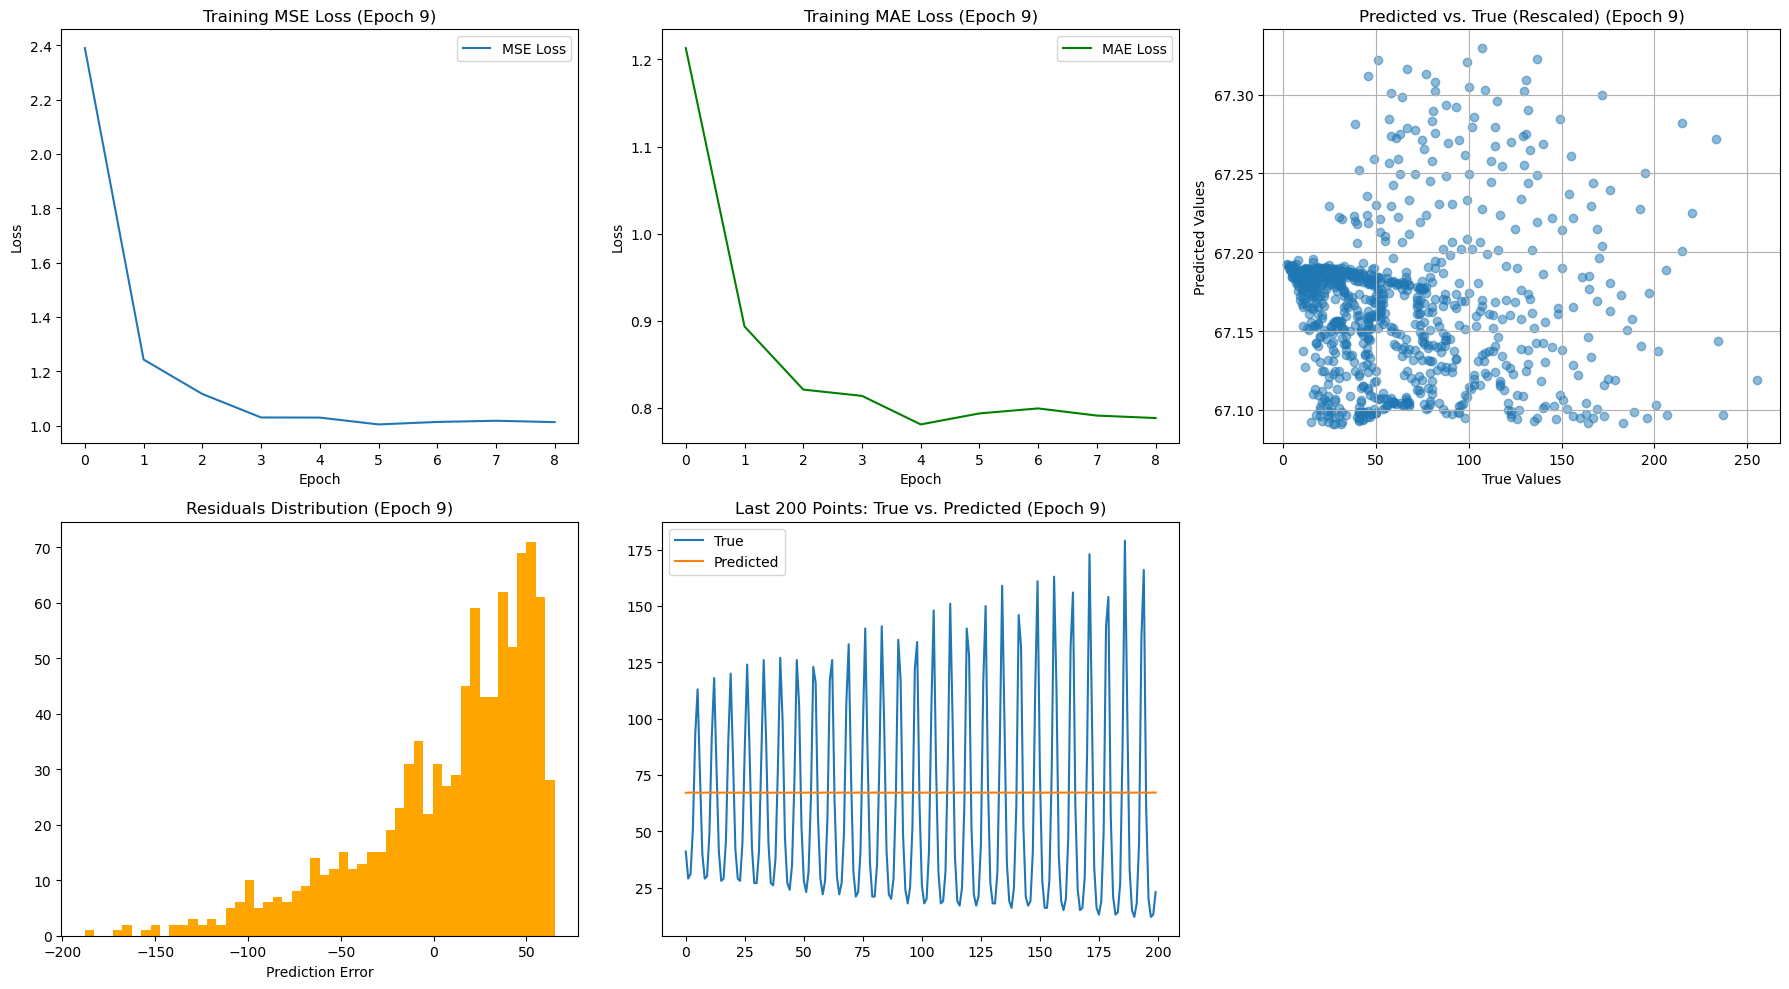

Plot exported to: training_epoch_9.png


Epoch 10/20: 100%|██████████| 15/15 [00:07<00:00,  2.11it/s, mse=0.814]


Epoch 10: MSE=1.0051, MAE=0.7892


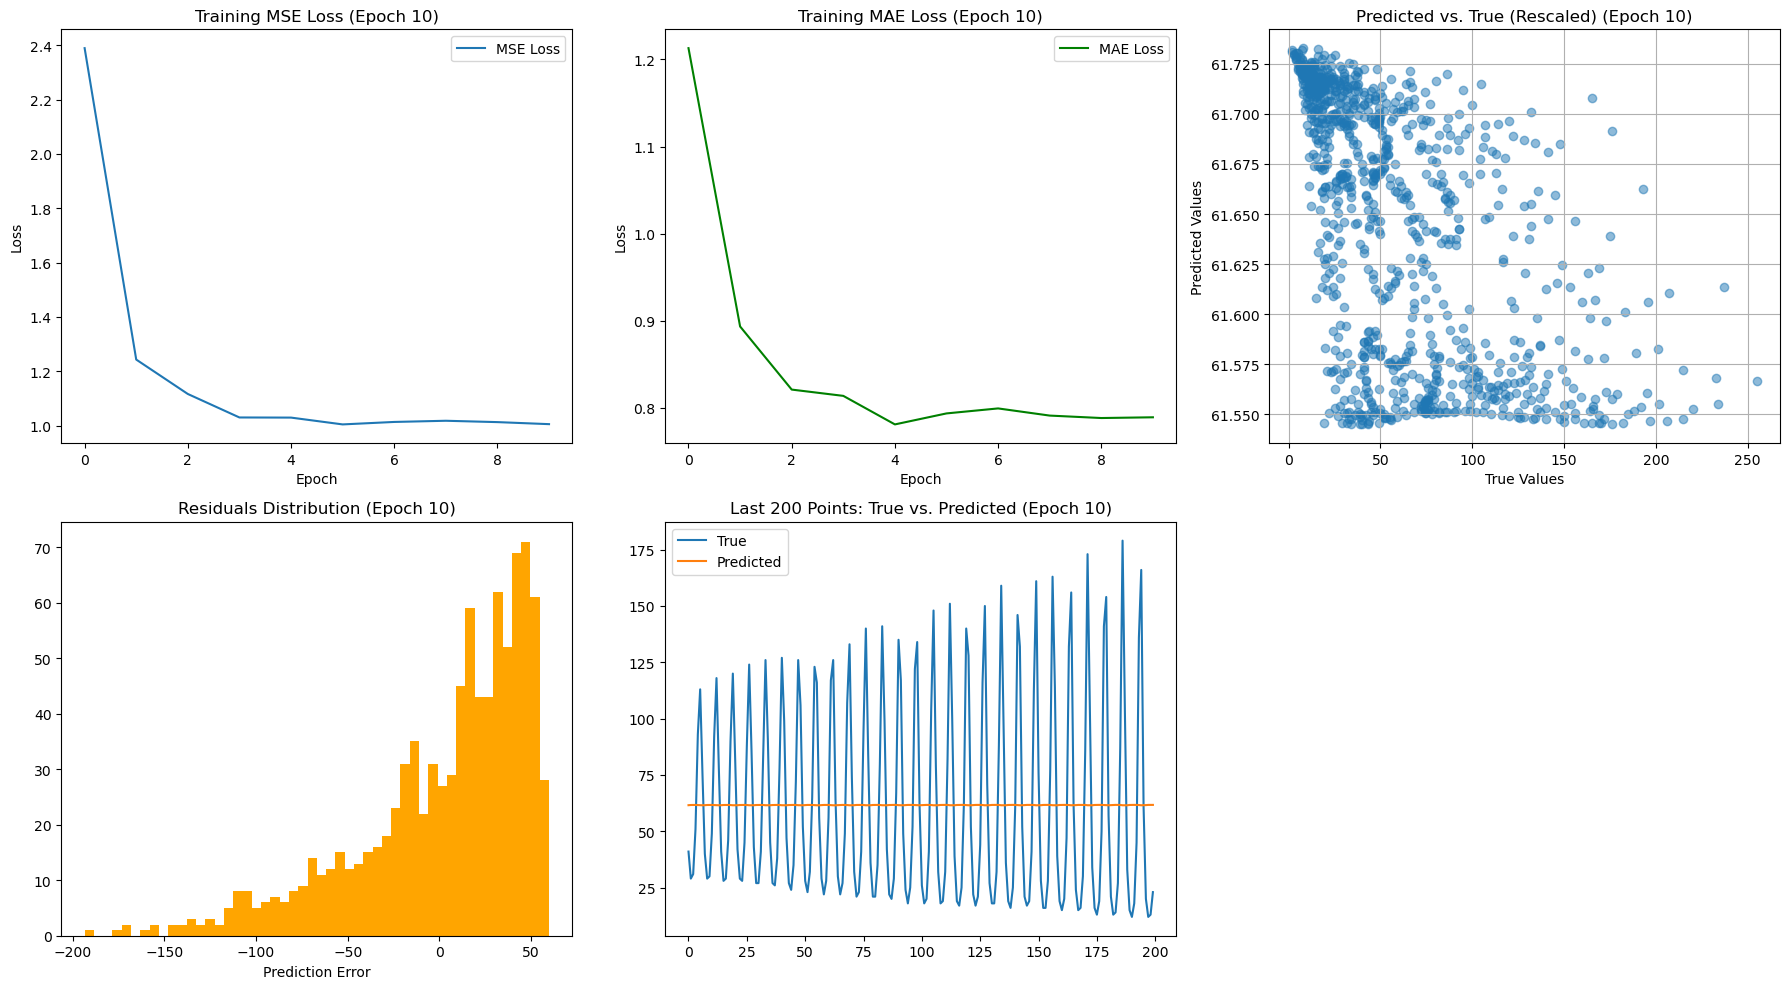

Plot exported to: training_epoch_10.png


Epoch 11/20: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s, mse=0.804]


Epoch 11: MSE=1.0137, MAE=0.8056


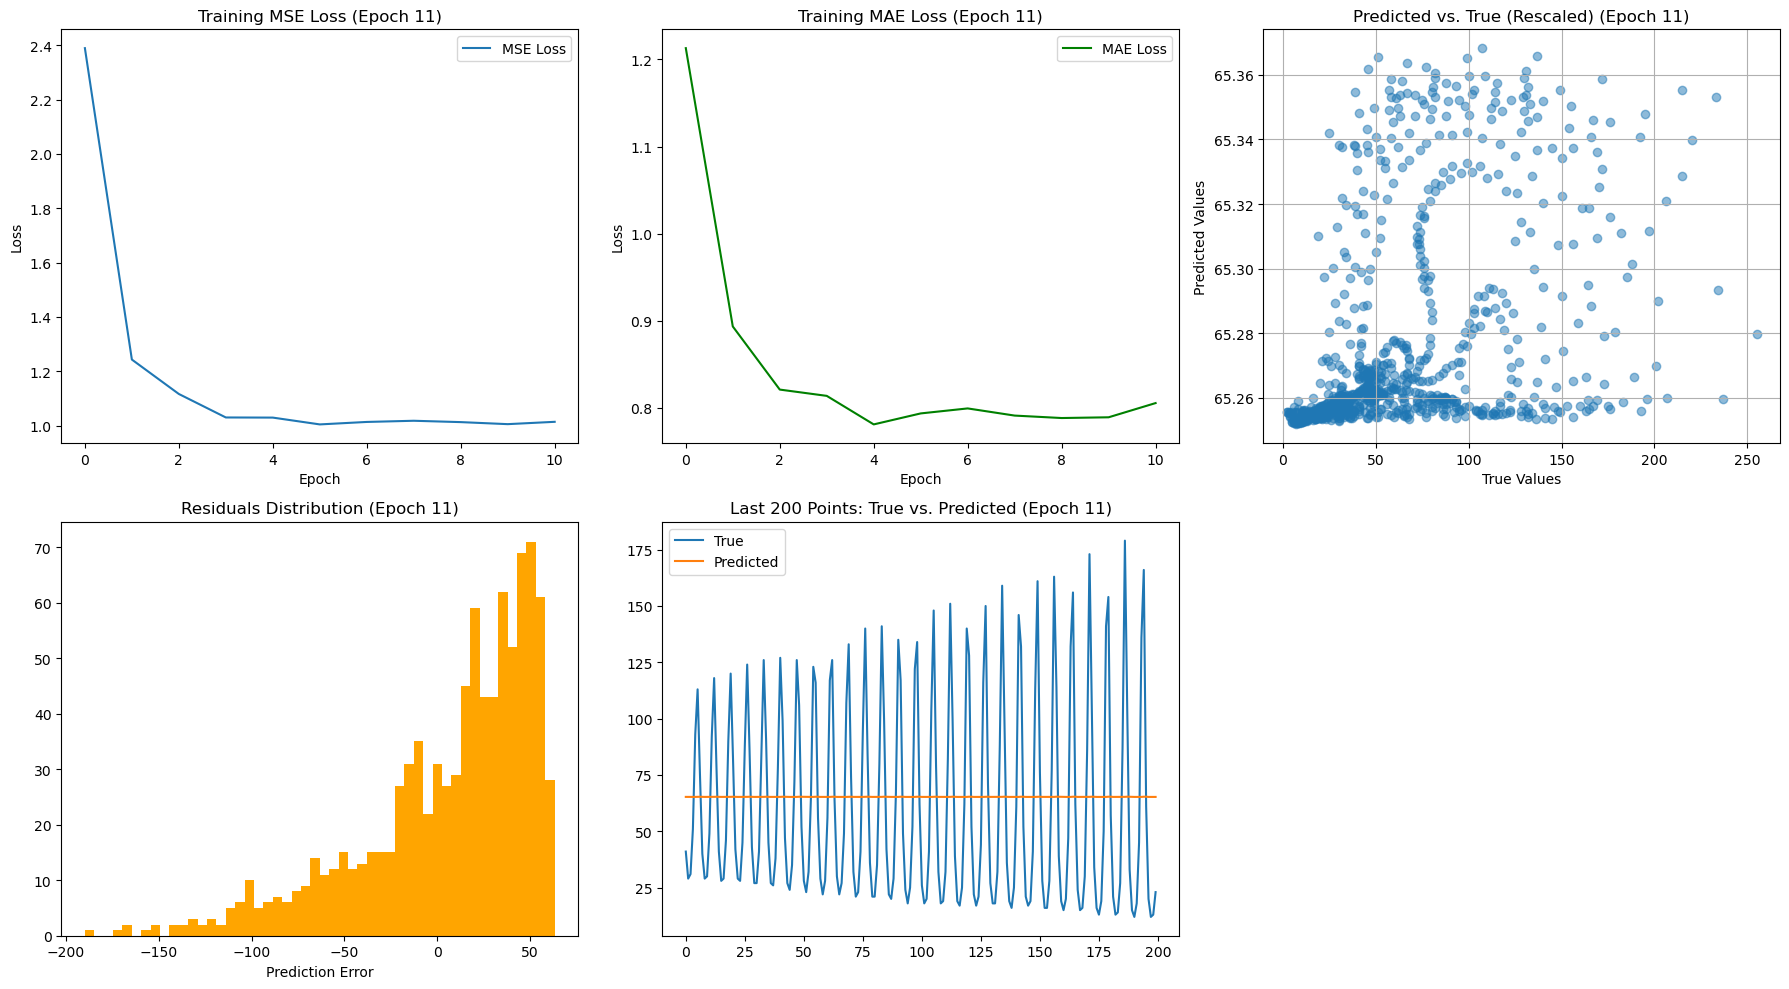

Plot exported to: training_epoch_11.png


Epoch 12/20: 100%|██████████| 15/15 [00:05<00:00,  2.82it/s, mse=0.897]


Epoch 12: MSE=1.0008, MAE=0.7890


In [8]:
window_size = 60  # Start here; tune this later
dataloader, X_all, y_all = prepare_dataloader(Xtrain_normalize, window_size)

model = TimeSeriesTransformer()
losses, accuracies = train_model(model, dataloader, X_all, y_all, std, mean, epochs=20)

